### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial

In [2]:
from pathlib import Path
PATH = Path('data/top/')

In [3]:
trn_store = pd.HDFStore(PATH/'train.h5')

In [4]:
type(trn_store)

pandas.io.pytables.HDFStore

In [5]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    return df

In [144]:
df = load_df(trn_store, 100000, 10)

In [145]:
train_feats = [f for f in df.columns if f != 'gen_target']

In [146]:
df[train_feats] = df[train_feats].replace(0.0, np.nan)

In [147]:
df

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,7_pz,8_e,8_px,8_py,8_pz,9_e,9_px,9_py,9_pz,gen_target
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,-9.317527,11.226108,-5.981516,-5.456269,-7.776638,10.445061,-5.460625,-4.854525,-7.464211,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,-6.715529,19.354494,14.770697,10.426314,-6.907601,19.159235,15.236702,9.403827,-6.818152,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,35.242985,30.382032,4.197567,-17.156092,24.720778,28.893793,2.911723,-15.084988,24.470724,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,-92.613403,34.859463,9.806834,-7.581288,-32.581165,32.415459,9.238444,-7.266585,-30.209435,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,-31.300266,23.398998,-11.141569,3.428889,-20.288452,30.679037,-7.839568,-6.483351,-28.943232,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,90.268028,-4.195592,60.712791,66.668358,69.045715,-14.976274,55.222778,38.645393,61.094059,-36.087658,...,21.467844,34.220341,-2.330091,23.279377,24.973448,24.976463,-5.639832,18.989082,15.212851,1
271,132.212692,43.556278,-112.529976,54.037483,94.046890,37.924595,-75.330620,41.615387,46.818245,15.029334,...,9.251928,22.894075,11.197651,-13.387837,14.816110,20.342255,10.001626,-12.284292,12.762092,1
272,109.807640,79.601105,75.243454,7.733328,89.442841,64.155067,62.151707,4.616718,75.744568,54.441364,...,1.380350,24.043293,7.260694,22.340012,5.127001,21.280718,19.319235,6.623101,5.980855,1
273,85.591797,35.005562,-52.951084,-57.417320,58.237534,30.108309,-47.242771,-15.912910,57.301460,29.624367,...,-19.479673,23.728998,13.288364,-18.860569,-5.546498,30.072861,11.538883,-19.084595,-20.174473,1


In [148]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')

In [149]:
df[train_feats] = input_pipe.transform(df[train_feats])

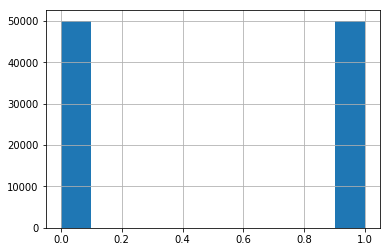

In [150]:
df.gen_target.hist()

In [151]:
df['gen_weight'] = 1
for c in df.gen_target.unique(): df.loc[df.gen_target == c, 'gen_weight'] *= 1/len(df[df.gen_target == c])

In [152]:
df.gen_weight.sum()

1.9999999999999998

In [153]:
from lumin.data_processing.hep_proc import get_vecs

In [154]:
fpv = ['px', 'py', 'pz', 'e']
vecs = sorted(list(get_vecs(train_feats)))

In [155]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=df, n_folds=10,
            cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
            wgt_feat='gen_weight',
            savename=PATH/'train', targ_type='int', strat_key='gen_target')

Saving fold 0 with 10000 events
Saving fold 1 with 10000 events
Saving fold 2 with 10000 events
Saving fold 3 with 10000 events
Saving fold 4 with 10000 events
Saving fold 5 with 10000 events
Saving fold 6 with 10000 events
Saving fold 7 with 10000 events
Saving fold 8 with 10000 events
Saving fold 9 with 10000 events


In [156]:
from lumin.nn.data.fold_yielder import *

In [157]:
train_fy = HEPAugFoldYielder(PATH/'train.hdf5')

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [158]:
import torch

In [189]:
a = nn.RNNCell(5,10)

In [191]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

tensor([[ 0.4725,  0.0193,  0.3515,  0.6987,  0.4057],
        [-0.2192, -0.7329,  0.4794,  0.1592, -0.3995],
        [ 0.3550,  0.3368, -0.0988,  0.2770, -0.8210]])

In [295]:
class NewRnn(RecurrentHead):
    def __init__(self, cont_feats:List[str], vecs:List[str], feats_per_vec:List[str],
                 depth:int, width:int, bidirectional:bool=False, rnn:nn.RNNBase=nn.RNN,
                 do:float=0., act:str='tanh', stateful:bool=False, freeze:bool=False, **kargs):
        super().__init__(cont_feats=cont_feats, vecs=vecs, feats_per_vec=feats_per_vec, row_wise=True, depth=depth,
                         width=width, bidirectional=bidirectional, rnn=rnn,
                         do=do, act=act, stateful=stateful, freeze=freeze)
        self._init_rnn()
    
    def _init_rnn(self) -> None:
        for name, param in self.rnn.named_parameters():
            if 'bias' in name:        nn.init.zeros_(param)
            elif 'weight_ih' in name: nn.init.orthogonal_(param)    
            if isinstance(self.rnn, nn.RNN):
                if 'weight_hh' in name: nn.init.orthogonal_(self.rnn.state_dict()[name])
            elif isinstance(self.rnn, nn.LSTM):
                if 'bias' in name: self.rnn.state_dict()[name][self.rnn.hidden_size:self.rnn.hidden_size*2].fill_(1)  # Forget bias -> 1
                elif 'weight_hh' in name:
                    for i in range(4): nn.init.orthogonal_(self.rnn.state_dict()[name][i*self.rnn.hidden_size:(i+1)*self.rnn.hidden_size])
            elif isinstance(self.rnn, nn.GRU):
                if 'bias' in name: self.rnn.state_dict()[name][:self.rnn.hidden_size].fill_(-1)  # Reset bias -> -1
                elif 'weight_hh' in name:
                    for i in range(3): nn.init.orthogonal_(self.rnn.state_dict()[name][i*self.rnn.hidden_size:(i+1)*self.rnn.hidden_size])

In [304]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import MultiHead, RecurrentHead


from torch import nn

n_models = 1
patience = 50
max_epochs = 15

ensemble_size = 10
ensemble_mode = 'loss'

bs = 256
objective = 'classifier'
model_args = {'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}
head = partial(RecurrentHead, vecs=vecs, feats_per_vec=fpv,
               depth=1, width=10, rnn=nn.LSTM, act='relu', bidirectional=True)
body = partial(FullyConnected, depth=4, width=40, act='swish', dense=True)
                       
opt_args = {'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                             model_args=model_args, opt_args=opt_args, head=head,body=body)

m = Model(model_builder)
m

No optimiser specified, defaulting to ADAM


Inputs:
40 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): RecurrentHead(
    (rnn): LSTM(4, 10, batch_first=True, bidirectional=True)
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=40, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=60, out_features=40, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=100, out_features=40, bias=True)
        (1): Swish()
      )
      (3): Sequential(
 

In [305]:
for w in m.head.named_parameters(): print(w)

('rnn.weight_ih_l0', Parameter containing:
tensor([[ 0.1830,  0.1335,  0.0819,  0.2204],
        [ 0.1598,  0.1861,  0.2766, -0.0056],
        [-0.1905, -0.3531,  0.2780,  0.0201],
        [ 0.1084,  0.0017, -0.0405, -0.2235],
        [-0.0453,  0.1344, -0.2661,  0.2753],
        [ 0.0543,  0.0398, -0.1415,  0.0195],
        [ 0.0347,  0.0321,  0.0821,  0.2094],
        [-0.1327,  0.0532,  0.1946,  0.0148],
        [-0.1790,  0.0347,  0.2006, -0.1178],
        [-0.2954, -0.0371, -0.0506,  0.0081],
        [ 0.0032, -0.0931, -0.0411,  0.0039],
        [ 0.0585,  0.1994, -0.1116, -0.1731],
        [ 0.0155,  0.0387,  0.1141,  0.0914],
        [ 0.1751,  0.0977,  0.0268, -0.0166],
        [-0.0215,  0.0497, -0.1618, -0.0109],
        [-0.0836, -0.1658,  0.0380,  0.2145],
        [-0.1987,  0.0496,  0.0168, -0.3916],
        [ 0.2164, -0.1269,  0.2456, -0.1043],
        [-0.0541,  0.2618, -0.0648,  0.0757],
        [ 0.0981,  0.0518, -0.1233, -0.3357],
        [ 0.3029, -0.2670, -0.0914,  

LR finder took 10.674s 


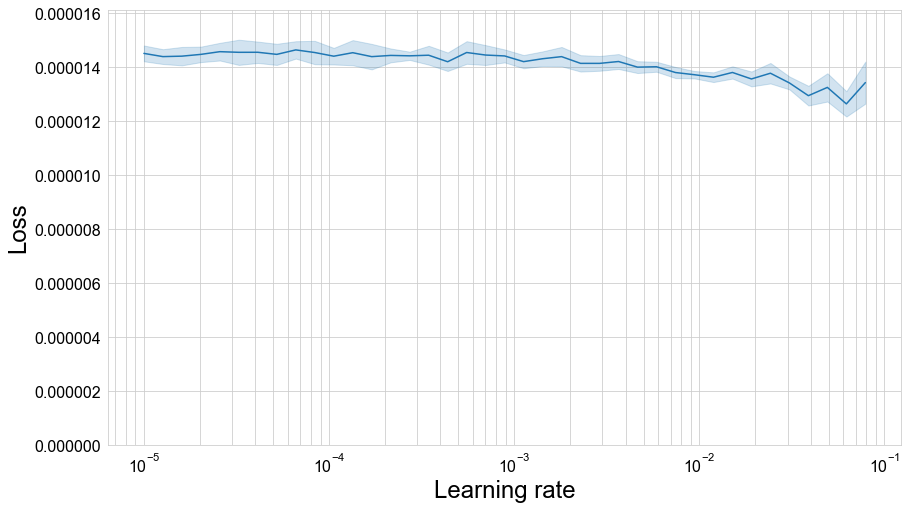

In [306]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [292]:
from sklearn.metrics import roc_auc_score
from lumin.nn.metrics.eval_metric import EvalMetric

class AUC(EvalMetric):
    def __init__(self, wgt_name:Optional[str]=None, targ_name:str='targets'):
        super().__init__(targ_name=targ_name, wgt_name=wgt_name)

    def evaluate(self, fy:FoldYielder, idx:int, y_pred:np.ndarray) -> float:
        df = self.get_df(fy, idx, y_pred)
        return roc_auc_score(df['gen_target'], df['pred'], sample_weight=df['gen_weight'])

In [293]:
from lumin.nn.callbacks.cyclic_callbacks import *
from functools import partial

callback_partials = [partial(OneCycle, lengths=[45, 90], lr_range=[3e-4, 3e-2], mom_range=[0.85, 0.95], interp='cosine')]
eval_metrics = {'AUC':AUC(wgt_name='weights')}

Training model 1 / 1, Val ID = 0


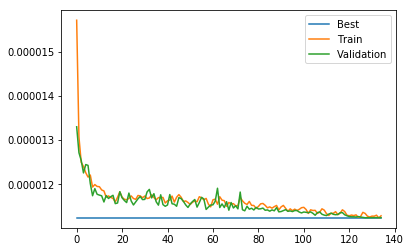

Early stopping after 135 epochs
Scores are: {'loss': 1.1246176654822193e-05, 'AUC': 0.7546824429967636}
Fold took 76.124s


______________________________________
Training finished
Cross-validation took 76.128s 


<Figure size 432x288 with 0 Axes>

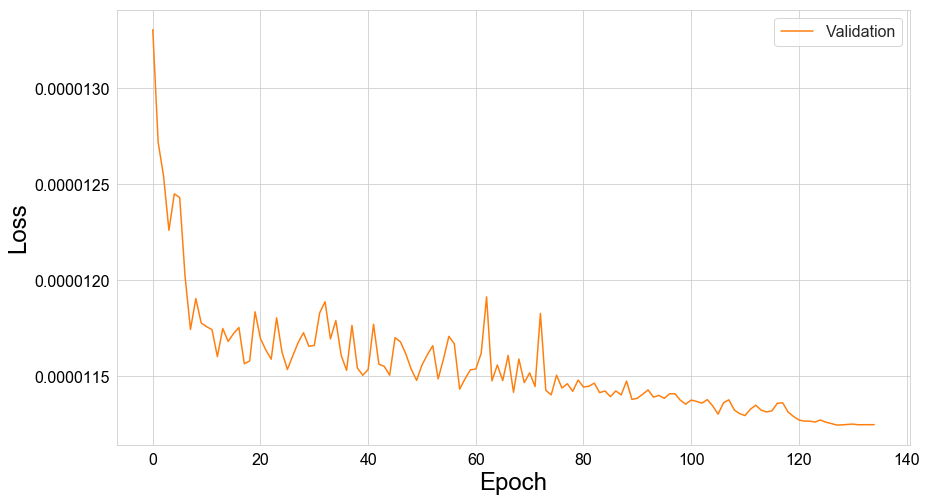

Mean loss = 1.1246176654822193e-05±0.0
Mean AUC = 0.7546824429967636±0.0
______________________________________



In [294]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)

Training model 1 / 1, Val ID = 0


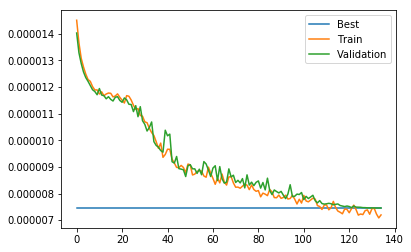

Early stopping after 135 epochs
Scores are: {'loss': 7.45519855627208e-06, 'AUC': 0.9032592380859124}
Fold took 102.378s


______________________________________
Training finished
Cross-validation took 102.381s 


<Figure size 432x288 with 0 Axes>

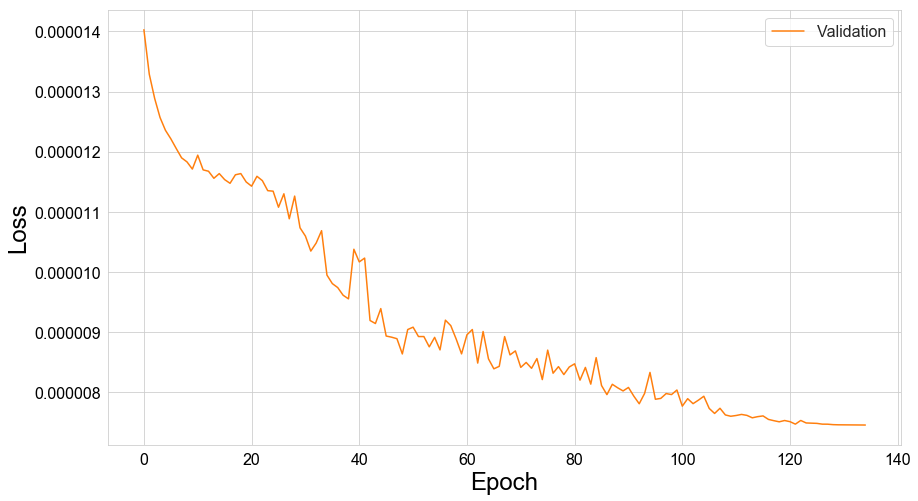

Mean loss = 7.45519855627208e-06±0.0
Mean AUC = 0.9032592380859124±0.0
______________________________________



In [272]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)

Training model 1 / 1, Val ID = 0


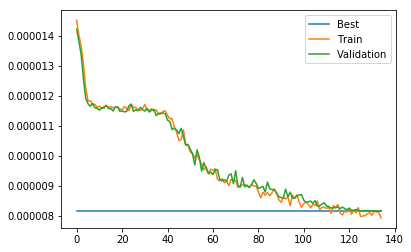

Early stopping after 135 epochs
Scores are: {'loss': 8.16466854303144e-06, 'AUC': 0.8863719072780205}
Fold took 128.368s


______________________________________
Training finished
Cross-validation took 128.371s 


<Figure size 432x288 with 0 Axes>

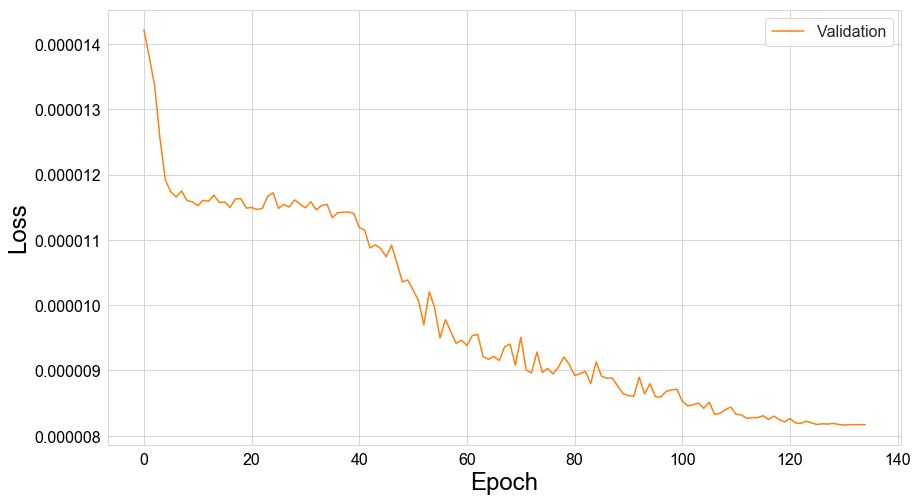

Mean loss = 8.16466854303144e-06±0.0
Mean AUC = 0.8863719072780205±0.0
______________________________________



In [265]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)